In [2]:
# Data manipulation libraries
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling and Metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

# calculating the geographical distance
from geopy.distance import geodesic


### Goals

- Group customers based on transaction patterns, geography, spending habits, and fraud risk.

- Identify high-risk customer segments for targeted fraud prevention measures.

In [3]:
base_path = os.path.expanduser('~/Desktop/Project 737')  
file_name = 'credit_card_transactions.csv'
file_path = os.path.join(base_path, file_name)

# Read the CSV file
credit_df = pd.read_csv(file_path)
credit_df.head(2)
#credit_df = pd.read_csv('/Users/anushkachougule/Desktop/Project 737/credit_card_transactions.csv')
#credit_df.head(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN


In [78]:
print(f"Number of rows: {credit_df.shape[0]}")
print(f"Number of columns: {credit_df.shape[1]}")

Number of rows: 1296675
Number of columns: 24


In [4]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

The dataset contains 1,296,675 rows and 24 columns, with various data types including integers, floats, and objects; most columns have complete data, except for merch_zipcode which has missing values.

In [5]:
credit_df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.100702e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03,4.682575e+04
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02,2.583400e+04
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00,1.001000e+03
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00,2.511400e+04
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00,4.586000e+04
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00,6.831900e+04
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00,9.940300e+04


The dataset's numerical summary reveals key statistics such as means, standard deviations, and range (min to max) for 12 columns, with notable features like amt (transaction amount) ranging from $1 to $28,948.90, and is_fraud indicating a maximum of 1, signifying binary fraud classification.

In [6]:
#Examining if there is any missing data.
missing_counts = credit_df.isnull().sum()
missing_counts_df = pd.DataFrame(missing_counts).reset_index()
missing_counts_df.columns = ['Feature', 'Missing Value Count']
missing_counts_df

,Feature,Missing Value Count
0,Unnamed: 0,0
1,trans_date_trans_time,0
2,cc_num,0
3,merchant,0
4,category,0
5,amt,0
6,first,0
7,last,0
8,gender,0
9,street,0


In [7]:
#Checking the number of unique values in each column.
unique_counts = credit_df.nunique()
unique_counts_df = pd.DataFrame(unique_counts).reset_index()
unique_counts_df.columns = ['Feature', 'Number of Unique Values'] 
unique_counts_df

,Feature,Number of Unique Values
0,Unnamed: 0,1296675
1,trans_date_trans_time,1274791
2,cc_num,983
3,merchant,693
4,category,14
5,amt,52928
6,first,352
7,last,481
8,gender,2
9,street,983


In [8]:
#Let's check if there is any duplications.
print(f'Number of duplicated rows: {credit_df.duplicated().sum()}')

Number of duplicated rows: 0


### Exploratory Data Analysis

In [9]:
segmentation_df = credit_df.copy()

In [10]:
drop_column = ['Unnamed: 0', 'first', 'last', 'street', 'zip', 'trans_num','unix_time','merch_zipcode']
segmentation_df = segmentation_df.drop(columns=drop_column)

The code removes unnecessary columns such as identifiers (Unnamed: 0, trans_num), metadata (unix_time), and personal information (first, last, street, etc.) from the dataset to streamline the analysis and focus on relevant features.

In [11]:
segmentation_df['trans_date_trans_time'] = pd.to_datetime(segmentation_df['trans_date_trans_time'])
segmentation_df['dob'] = pd.to_datetime(segmentation_df['dob'])

We convert the trans_date_trans_time and dob columns in the dataset to datetime format, enabling easier manipulation and analysis of date and time information for these fields.

In [12]:
current_year = pd.Timestamp.now().year
segmentation_df['age'] = current_year - segmentation_df['dob'].dt.year

Calculating the age of each individual by subtracting the year of birth (dob) from the current year and stores the result in a new column, age, in the dataset.

In [13]:
# Define age groups
bins = [18, 25, 35, 45, 55, 65, 75, 85, 95, 105]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-95', '96-105']
segmentation_df['age_group'] = pd.cut(segmentation_df['age'], bins=bins, labels=labels, right=False)

# Check segments
segmentation_df[['age', 'age_group', 'gender', 'city', 'state']].head()

,age,age_group,gender,city,state
0,36,36-45,F,Moravian Falls,NC
1,46,46-55,F,Orient,WA
2,62,56-65,M,Malad City,ID
3,57,56-65,M,Boulder,MT
4,38,36-45,M,Doe Hill,VA


Here, we group customers into predefined age ranges using pd.cut and assigns each individual to an age_group category, enabling demographic analysis based on age segmentation.

In [14]:
segmentation_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,state,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,age,age_group
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,36.011293,-82.048315,0,36,36-45
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,49.159047,-118.186462,0,46,46-55
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,43.150704,-112.154481,0,62,56-65
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,1939,Patent attorney,1967-01-12,47.034331,-112.561071,0,57,56-65
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,38.674999,-78.632459,0,38,36-45


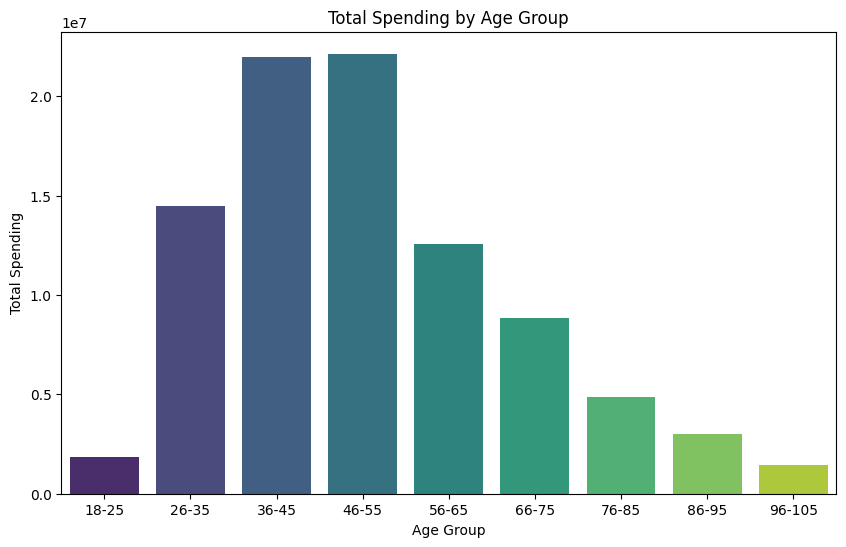

In [15]:
# Analyzing spending patterns within each group
age_spending = segmentation_df.groupby('age_group')['amt'].agg(['sum', 'mean']).reset_index()

#plot
plt.figure(figsize=(10, 6))
sns.barplot(data=age_spending, x='age_group', y='sum', palette='viridis')
plt.title('Total Spending by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Spending')
plt.show()

This bar plot illustrates the total spending across different age groups. The data reveals that individuals in the 36-45 and 46-55 age groups have the highest total spending, indicating they are the most financially active demographics. Conversely, younger (18-25) and older (96-105) age groups exhibit the lowest spending, reflecting their lower transaction activity. This insight can help businesses target age groups with tailored marketing and services.

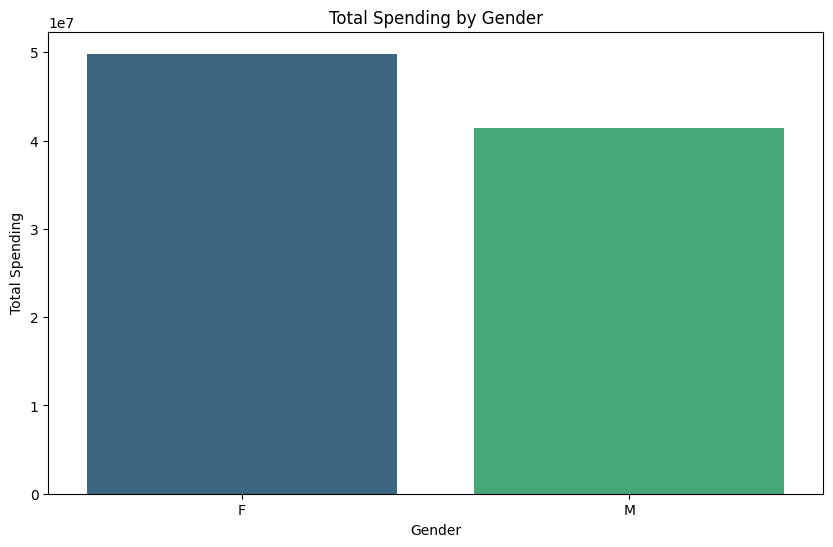

In [16]:
# Calculate total and average spending by gender
gender_spending = segmentation_df.groupby('gender')['amt'].agg(['sum', 'mean']).reset_index()

#Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=gender_spending, x='gender', y='sum', palette='viridis')
plt.title('Total Spending by Gender')
plt.xlabel('Gender')
plt.ylabel('Total Spending')
plt.show()

This bar plot shows the total spending segmented by gender. Female customers (F) have a slightly higher total spending compared to male customers (M). This insight suggests that businesses might focus more on female customers when designing marketing strategies or promotional offers, as they appear to contribute more to overall transactions.

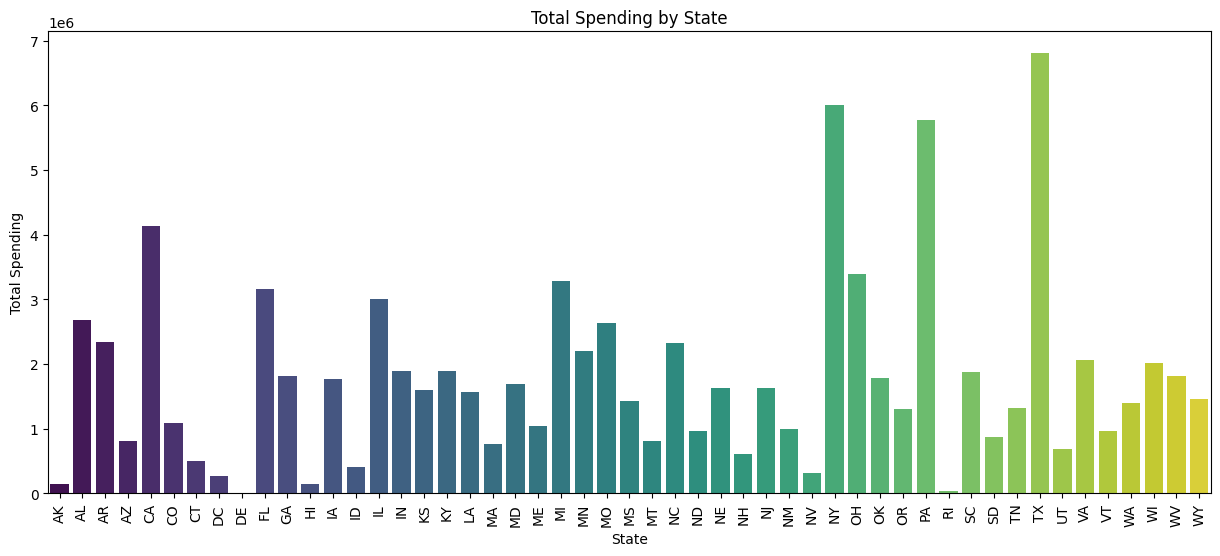

In [17]:
# Calculate total and average spending by state
state_spending = segmentation_df.groupby('state')['amt'].agg(['sum', 'mean']).reset_index()

#plot
# Plot spending patterns by state
plt.figure(figsize=(15, 6))
sns.barplot(data=state_spending, x='state', y='sum', palette='viridis')
plt.title('Total Spending by State')
plt.xlabel('State')
plt.ylabel('Total Spending')
plt.xticks(rotation=90)
plt.show()

This bar plot illustrates the total spending across different U.S. states. Notably, states like Texas (TX) and California (CA) exhibit significantly higher total spending compared to other states, indicating these regions might have larger customer bases or higher purchasing activity. Such insights can help businesses prioritize marketing efforts or resource allocation in high-spending states to maximize impact.

In [36]:
# Identify high-value age group
high_value_age_group = age_spending.sort_values(by='sum', ascending=False).head(1)
print(f'High-Value Age Group: {high_value_age_group}')

High-Value Age Group:   age_group          sum       mean
3     46-55  22142185.88  73.542045


The age group 46-55 has the highest total spending, amounting to $22,142,185.88, with an average transaction amount of $73.54. This highlights the 46-55 age group as a high-value customer segment, suggesting targeted marketing strategies could be particularly effective for this demographic.

In [37]:
# Identify high-value gender
high_value_gender = gender_spending.sort_values(by='sum', ascending=False).head(1)
print(f'High-Value Gender: {high_value_gender}')

High-Value Gender:   gender          sum       mean
0      F  49832612.83  70.200324


The female gender is the highest contributor to total spending, with a total amount of $49,832,612.83 and an average transaction amount of $70.20. This highlights females as a high-value customer segment, indicating potential opportunities for gender-specific marketing strategies.

In [38]:
# Identify high-value state
high_value_state = state_spending.sort_values(by='sum', ascending=False).head(1)
print(f'High-Value State: {high_value_state}')

High-Value State:    state         sum      mean
43    TX  6800917.53  71.68217


The state of Texas (TX) emerges as the highest contributor to total spending, with a total amount of $6,800,917.53 and an average transaction amount of $71.68. This highlights Texas as a high-value geographic region, suggesting opportunities for location-based marketing and tailored business strategies.

In [26]:
# Aggregate transaction data by customer
customer_data = segmentation_df.groupby('cc_num').agg({
    'amt': ['mean', 'sum', 'count'],       # Transaction patterns
    'is_fraud': 'sum',                    # Total fraud count
    'city_pop': 'mean',                   # Average population of cities where transactions occurred
    'age': 'mean'                         # Average age of the customer
}).reset_index()

# Rename columns for clarity
customer_data.columns = ['cc_num', 'avg_amt', 'total_amt', 'transaction_count', 'fraud_count', 'avg_city_pop', 'avg_age']

# Display the first few rows
customer_data.head()

,cc_num,avg_amt,total_amt,transaction_count,fraud_count,avg_city_pop,avg_age
0,60416207185,56.023366,85043.47,1518,9,1645.0,38.0
1,60422928733,69.000784,105640.20,1531,12,46944.0,82.0
2,60423098130,115.046333,58673.63,510,10,83.0,66.0
3,60427851591,111.987898,59129.61,528,14,2142.0,48.0
4,60487002085,50.726028,25160.11,496,0,233060.0,52.0


Aggregating customer-level transaction data, summarizing metrics like average and total transaction amounts, transaction count, fraud occurrences, average city population, and customer age, providing a consolidated view for analysis and segmentation.

In [27]:
# Select features for clustering
features = ['avg_amt', 'total_amt', 'transaction_count', 'fraud_count', 'avg_city_pop', 'avg_age']
scaler = StandardScaler()

# Standardize the selected features
scaled_features = scaler.fit_transform(customer_data[features])

# Verify the scaled features
print(scaled_features[:5])


[[-0.37517631 -0.13024312  0.24500463  0.28023017 -0.30344511 -0.86870175]
 [-0.2866061   0.21560383  0.26101798  0.89648577 -0.16299903  1.51795188]
 [ 0.02765243 -0.57302841 -0.99664587  0.4856487  -0.30828797  0.65007783]
 [ 0.00677876 -0.56537189 -0.97447354  1.30732284 -0.3019042  -0.32628047]
 [-0.41133037 -1.13576574 -1.01389102 -1.56853664  0.41403937 -0.10931196]]


Selecting key features such as average amount, total amount, transaction count, fraud count, average city population, and average age for clustering. These features are standardized using StandardScaler to ensure they are on the same scale, enabling effective clustering analysis. The first five scaled feature values are printed for verification.

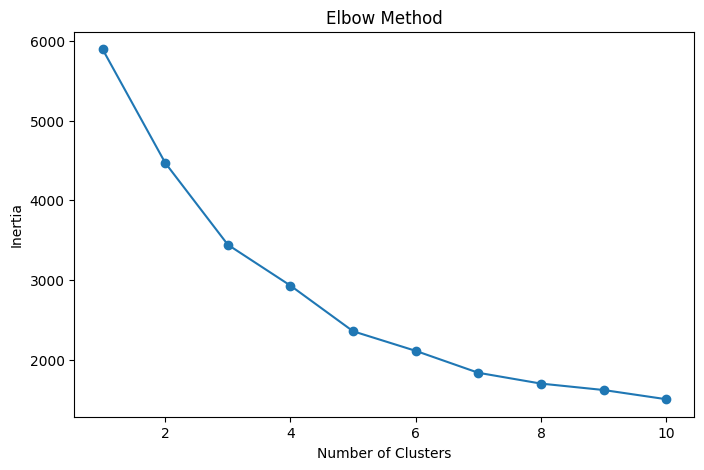

In [29]:
# Determine optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    
# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

This plot demonstrates the Elbow Method used to determine the optimal number of clusters for K-Means clustering. The x-axis represents the number of clusters, and the y-axis shows the inertia (sum of squared distances to the nearest cluster center). The "elbow point," where the rate of decrease in inertia slows significantly, suggests the ideal number of clusters. In this case, the elbow point appears around 4 or 5 clusters, indicating a suitable choice for segmentation.

In [39]:
# Apply K-Means with the optimal number of clusters
optimal_clusters = 5 # Replace with the optimal number from the Elbow Curve
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)
# Display the first few rows with cluster labels
customer_data.head()



,cc_num,avg_amt,total_amt,transaction_count,fraud_count,avg_city_pop,avg_age,Cluster
0,60416207185,56.023366,85043.47,1518,9,1645.0,38.0,1
1,60422928733,69.000784,105640.20,1531,12,46944.0,82.0,1
2,60423098130,115.046333,58673.63,510,10,83.0,66.0,1
3,60427851591,111.987898,59129.61,528,14,2142.0,48.0,1
4,60487002085,50.726028,25160.11,496,0,233060.0,52.0,3


This code applies the K-Means clustering algorithm with the optimal number of clusters determined from the Elbow Curve (in this case, 5). Each customer is assigned to a specific cluster, which is added as a new column (Cluster) in the customer_data dataframe. This enables segmentation of customers based on their transaction patterns, fraud occurrences, and demographic data. The resulting dataframe provides a foundation for analyzing and visualizing the characteristics of each cluster.

In [42]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Compute validation metrics
silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
db_index = davies_bouldin_score(scaled_features, kmeans.labels_)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {db_index}")

Silhouette Score: 0.2933838943865393
Davies-Bouldin Index: 1.0708412396276494


The clustering results were evaluated using two key metrics:

- **Silhouette Score:** 0.2934  
  This score measures how well the clusters are separated and how cohesive they are. A value closer to 1 indicates better-defined and compact clusters. The moderate score suggests that the clusters are distinguishable but may have some overlap.

- **Davies-Bouldin Index:** 1.0708  
  This metric evaluates the separation and compactness of clusters, with lower values indicating better clustering. The result suggests reasonably well-defined clusters, though some refinement may be needed.

**Note on Class Imbalance:**  
The clustering results might be influenced by the inherent class imbalance in the dataset, particularly since the number of fraudulent transactions is significantly smaller than non-fraudulent ones. This imbalance could impact the clustering's ability to separate distinct groups effectively, which is reflected in the validation metrics.


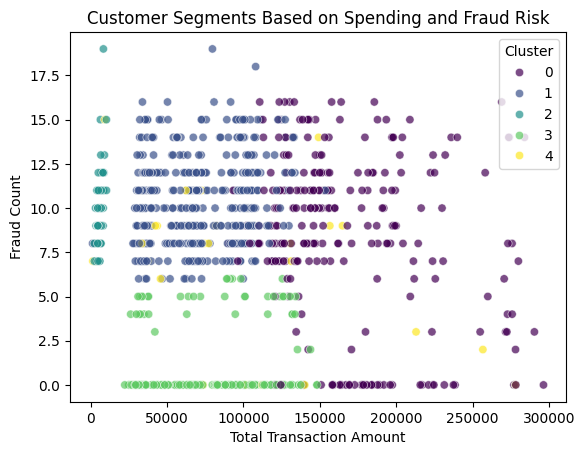

In [40]:
# Visualize clusters based on transaction patterns
sns.scatterplot(data=customer_data, x='total_amt', y='fraud_count', hue='Cluster', palette= 'viridis', alpha =0.7)
plt.title('Customer Segments Based on Spending and Fraud Risk')
plt.xlabel('Total Transaction Amount')
plt.ylabel('Fraud Count')
plt.legend(title='Cluster')
plt.show()

This scatter plot depicts customer segments based on total transaction amount (x-axis) and fraud count (y-axis), with clusters distinguished by color. The clusters were identified using K-Means clustering and highlight varying customer behaviors

In [115]:
# Compute summary statistics for each cluster
cluster_summary = customer_data.groupby('Cluster').agg({
    'total_amt': ['mean', 'median', 'max'],
    'fraud_count': ['mean', 'median', 'max'],
    'transaction_count': ['mean', 'median', 'max']
}).reset_index()

# Rename columns for better readability
cluster_summary.columns = [
    'Cluster', 
    'Avg_Total_Transaction_Amount', 'Median_Total_Transaction_Amount', 'Max_Total_Transaction_Amount',
    'Avg_Fraud_Count', 'Median_Fraud_Count', 'Max_Fraud_Count',
    'Avg_Transaction_Count', 'Median_Transaction_Count', 'Max_Transaction_Count'
]

# Display summary statistics
cluster_summary

,Cluster,Avg_Total_Transaction_Amount,Median_Total_Transaction_Amount,Max_Total_Transaction_Amount,Avg_Fraud_Count,Median_Fraud_Count,Max_Fraud_Count,Avg_Transaction_Count,Median_Transaction_Count,Max_Transaction_Count
0,0,167972.120965,155522.840,296436.73,8.266409,9.0,16,2307.111969,2093.0,3123
1,1,70335.028084,68431.325,153552.58,10.364486,10.0,19,1012.352804,1026.0,2080
2,2,5960.440270,5857.680,10437.00,9.905405,10.0,19,9.905405,10.0,19
3,3,77356.689054,71764.145,148374.33,0.882883,0.0,6,1194.202703,1043.0,2109


### Cluster Summary Statistics

The table below provides an overview of key metrics for each identified customer cluster, highlighting their spending patterns, fraud occurrences, and transaction behavior.

#### Key Metrics:
- **Transaction Amounts:**
  - Cluster 0: Highest average and maximum transaction amounts, indicating high-spending customers.
  - Cluster 2: Lowest average and maximum transaction amounts, representing low-spending customers.

- **Fraud Counts:**
  - Cluster 1: Highest average fraud count (10.36) and maximum fraud count (19), suggesting higher fraud risk.
  - Cluster 3: Lowest average fraud count (0.88), representing low-risk customers.

- **Transaction Counts:**
  - Cluster 0: Highest average transaction count (2307.11), indicating frequent transactions.
  - Cluster 2: Lowest average transaction count (9.91), reflecting low transaction frequency.

#### Observations:
- Cluster 0 represents high-value, high-frequency customers with moderate fraud risk.
- Cluster 1 has medium spenders with the highest fraud risk, requiring close monitoring.
- Cluster 2 includes low-spending, low-frequency customers, likely representing low-value customers.
- Cluster 3 represents moderate spenders with low fraud risk, indicating stable customer behavior.

These insights provide actionable data for tailoring marketing strategies and fraud prevention measures.


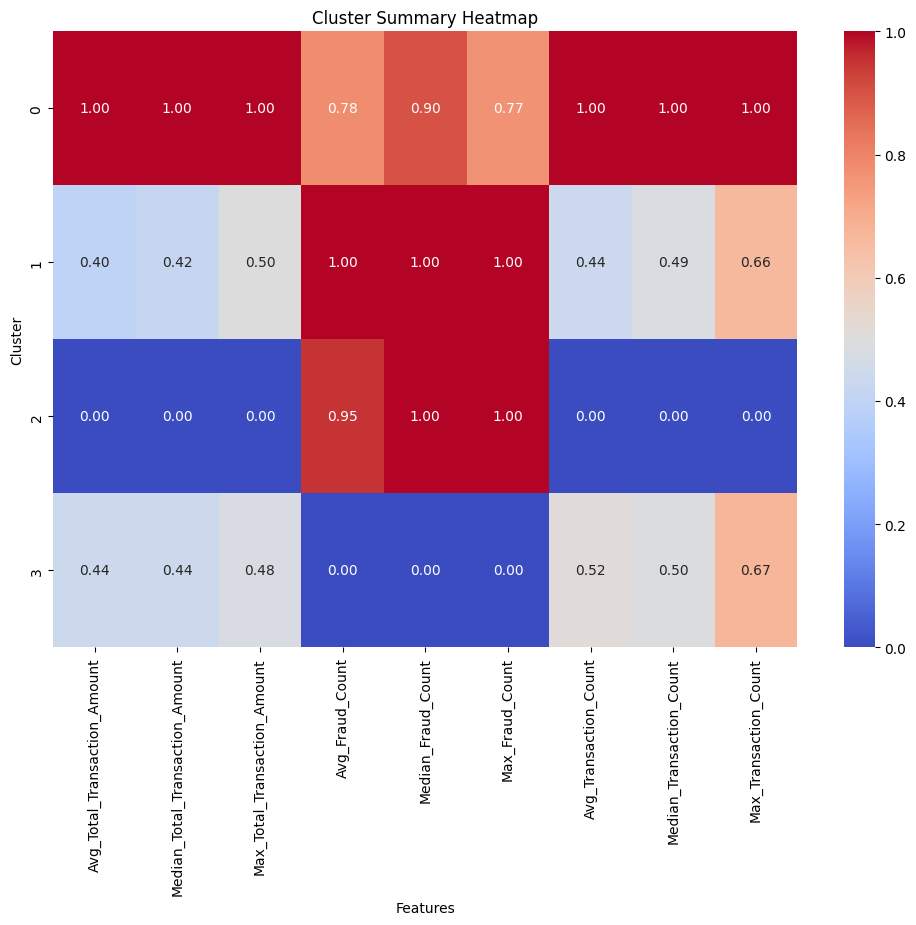

In [116]:
# Normalize the cluster_summary for better visualization
normalized_summary = cluster_summary.set_index('Cluster')
normalized_summary = (normalized_summary - normalized_summary.min()) / (normalized_summary.max() - normalized_summary.min())

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_summary, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cluster Summary Heatmap')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.show()

### Cluster Summary Heatmap

This heatmap visualizes the normalized summary statistics for each cluster, allowing for a quick comparison of key metrics such as transaction amounts, fraud counts, and transaction frequency.

#### Observations:
- **Cluster 0:** Dominates in all transaction-related metrics (total, median, and maximum transaction amounts), indicating high-value customers.
- **Cluster 1:** Displays the highest fraud-related metrics (average, median, and maximum fraud counts), suggesting a high fraud risk.
- **Cluster 2:** Features minimal transaction and fraud metrics, representing low-value, low-risk customers.
- **Cluster 3:** Shows moderate transaction and fraud metrics, reflecting stable and moderate-value customers.

This heatmap highlights the unique characteristics of each cluster, enabling data-driven strategies for customer targeting and fraud management.


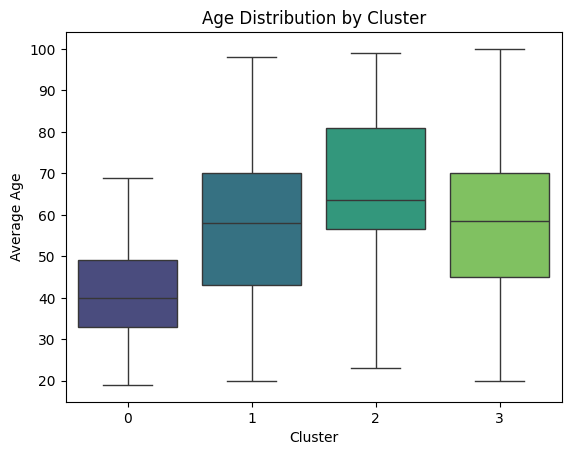

In [117]:
sns.boxplot(data=customer_data, x='Cluster', y='avg_age', palette='viridis')
plt.title('Age Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Age')
plt.show()


### Age Distribution by Cluster

This boxplot illustrates the age distribution across the identified clusters:

- **Cluster 0:** Represents younger customers with an average age in the 30s to 40s, and a relatively narrow age range.
- **Cluster 1:** Comprises middle-aged customers with ages mostly in the 50s to 60s, displaying a broader range.
- **Cluster 2:** Includes older customers, with a median age close to 70 and a wider age range extending into the 90s.
- **Cluster 3:** Captures a mix of customers primarily in their 50s, with a slightly narrower distribution compared to Cluster 2.

This distribution highlights the distinct age profiles of each cluster, offering insights into demographic trends that can inform targeted marketing strategies.


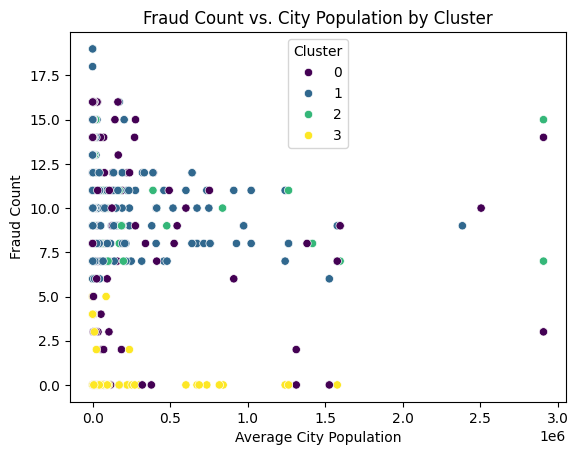

In [118]:
sns.scatterplot(data=customer_data, x='avg_city_pop', y='fraud_count', hue='Cluster', palette='viridis')
plt.title('Fraud Count vs. City Population by Cluster')
plt.xlabel('Average City Population')
plt.ylabel('Fraud Count')
plt.legend(title='Cluster')
plt.show()

### Fraud Count vs. City Population by Cluster

This scatter plot shows the relationship between the average city population and fraud count across different clusters:

- **Cluster 0:** Represents customers from smaller city populations with a moderate range of fraud counts.
- **Cluster 1:** Includes customers from both smaller and mid-sized cities, showing the highest fraud counts across all clusters.
- **Cluster 2:** Captures customers from a mix of city sizes, including the largest city populations, with mid-range fraud counts.
- **Cluster 3:** Primarily includes customers from smaller cities with lower fraud counts.

The plot highlights that while fraud occurrence is prevalent across various city sizes, specific clusters exhibit distinct patterns, offering insights into how urban demographics influence fraud risk.

### Conclusion and Recommendations

The customer segmentation analysis effectively grouped customers based on transaction patterns, spending habits, geographic factors, and fraud risk. Despite the dataset's class imbalance, which reflects real-world scenarios, the analysis provided actionable insights:

- **Cluster 0 (Purple):** Younger, high-value, low-risk customers. Focus on loyalty programs and personalized offers to drive retention.
- **Cluster 1 (Blue):** Medium-to-high spenders with the highest fraud risk. Implement proactive fraud detection and monitoring for large transactions.
- **Cluster 2 (Green):** Low-value, high-risk customers with concentrated fraud in moderately populated areas. Apply strict monitoring and intervention strategies.
- **Cluster 3 (Yellow):** Low-value, low-risk customers. Explore upselling opportunities to increase engagement.

### Recommendations
1. **Fraud Prevention:** Prioritize high-risk clusters (1 and 2) with enhanced monitoring systems and region-specific fraud detection strategies.
2. **Personalized Marketing:** Focus resources on retaining high-value customers in Cluster 0 while increasing engagement with Cluster 3.
3. **Operational Efficiency:** Allocate resources strategically, targeting high-risk clusters for fraud prevention and high-value clusters for marketing initiatives.

This analysis demonstrates the potential to tailor business strategies based on customer segmentation, addressing both fraud risks and marketing opportunities effectively.
